描述了一个具有L个隐藏层的深度循环神经网络， 每个隐状态都连续地传递到当前层的下一个时间步和下一层的当前时间步。

![深度循环神经网络](https://files.mdnice.com/user/23981/c84c37ac-552b-4669-bf7b-5be9bb8618e5.png)

# 简洁实现

实现多层循环神经网络所需的许多逻辑细节在高级API中都是现成的。 简单起见，我们仅示范使用此类内置函数的实现方式。 以长短期记忆网络模型为例， 该代码与之前在 9.2节中使用的代码非常相似， 实际上唯一的区别是我们指定了层的数量， 而不是使用单一层这个默认值。 像往常一样，我们从加载数据集开始。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

像选择超参数这类架构决策也跟 9.2节中的决策非常相似。 因为我们有不同的词元，所以输入和输出都选择相同数量，即vocab_size。 隐藏单元的数量仍然是。 唯一的区别是，我们现在通过num_layers的值来设定隐藏层数。

In [2]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

perplexity 1.0, 20271.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


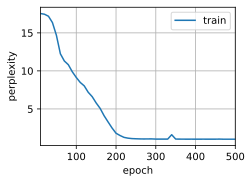

In [3]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr * 1.0, num_epochs, device)

# 双向循环神经网络

由于双向循环神经网络使用了过去的和未来的数据， 所以我们不能盲目地将这一语言模型应用于任何预测任务。 尽管模型产出的困惑度是合理的， 该模型预测未来词元的能力却可能存在严重缺陷。 我们用下面的示例代码引以为戒，以防在错误的环境中使用它们。

perplexity 1.1, 9866.3 tokens/sec on cuda:0
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


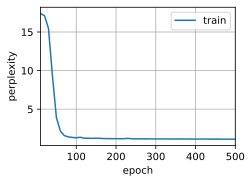

In [20]:
from torch import nn
from d2l import torch as d2l

#加载数据
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# 通过设置bidirectional=True来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer=nn.LSTM(num_inputs,num_hiddens,num_layers,bidirectional=True)
model=d2l.RNNModel(lstm_layer,len(vocab))
model=model.to(device)
#训练模型
num_epochs,lr=500,1
d2l.train_ch8(model,train_iter,vocab,lr,num_epochs,device)

# 从零实现

%%time  #显示每个cell的运行时间

In [4]:
% matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import time

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)  #导入数据

In [5]:
print(train_iter.__sizeof__())
for iter in train_iter:
    X, Y = iter
    print(X, Y)
    print(X.shape, Y.shape)  #(batch_size, num_steps)
    break

32
tensor([[ 3,  5, 13,  ..., 13,  2,  1],
        [ 9,  3,  1,  ...,  4,  8,  8],
        [ 1,  4,  1,  ...,  1, 12,  4],
        ...,
        [15,  7,  6,  ..., 21, 14,  3],
        [19,  8,  3,  ...,  8,  3,  1],
        [ 2, 15,  9,  ...,  4,  6, 11]]) tensor([[ 5, 13,  2,  ...,  2,  1,  3],
        [ 3,  1,  3,  ...,  8,  8,  2],
        [ 4,  1, 12,  ..., 12,  4, 25],
        ...,
        [ 7,  6, 26,  ..., 14,  3, 21],
        [ 8,  3,  4,  ...,  3,  1, 21],
        [15,  9,  4,  ...,  6, 11,  1]])
torch.Size([32, 35]) torch.Size([32, 35])


In [6]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [7]:
print(torch.cuda.device_count())

1


In [8]:
def get_gru_params(vocab_size, num_hiddens, device):
    """初始化参数"""
    num_inputs = num_outputs = vocab_size

    # 在循环神经网络（RNN）中，输入和输出都是序列数据，而每个时间步都需要处理一个单独的标记。 因此，输入和输出的词汇表必须相同，以便将标记与其对应的编码相匹配。在这种情况下，我们可以将num_inputs和 um_outputs设置为相同的值，使它们等于词汇表大小。
    # 相当于定义一个统一的解空间
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01  #乘以0.01主要是为了使生成的参数值更接近于0，避免梯度消失或爆炸

    def three():  #返回一个包含3个元素的元组
        return (normal((num_inputs, num_hiddens)),  #(num_inputs,num_hiddens)输入层与隐藏层之间权重
                normal((num_hiddens, num_hiddens)),  #(num_hiddens,num_hiddens)隐藏层与隐藏层间权重
                torch.zeros(num_hiddens, device=device))  #(num_hiddens,)偏置项

    W_xr, W_hr, b_r = three()  #重置门参数
    W_xz, W_hz, b_z = three()  #更新门参数
    W_xh, W_hh, b_h = three()  #候选状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))  #隐藏层和输出层之间参数
    b_q = torch.zeros(num_outputs, device=device)  #隐藏层和输出层之间偏置项
    # 将参数打包成列表
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [9]:
def init_gru_state(batch_size, num_hiddens, device):
    """初始化隐藏层状态"""
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [10]:
def gru(inputs, state, params, num_layers):
    """定义gru的前向传播过程"""
    # inputs是完成独热编码后的张量，不是原始输入
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params  #参数
    H, = state  #上一个隐藏层的状态
    outputs = []
    for _ in range(num_layers):
        for X in inputs:
            # X(batch_size,vocab_size)
            # W(num_inputs,num_hiddens)(num_hiddens,num_hiddens)
            # b(num_hiddens,)
            # H(batch_size, num_hiddens)
            R = torch.sigmoid(torch.mm(X, W_xr) + torch.mm(H, W_hr) + b_r)  #(batch_size,num_hiddens)
            Z = torch.sigmoid(torch.mm(X, W_xz) + torch.mm(H, W_hz) + b_z)  #(batch_size,num_hiddens)
            H_tilda = torch.tanh(torch.mm(X, W_xh) + torch.mm(R * H, W_hh) + b_h)
            H = (1 - Z) * H + Z * H_tilda
        inputs = H  #把输出的隐藏状态H作为第二层的输入（没测试过）
    Y = torch.mm(H, W_hq) + b_q  #(batch_size,1)
    outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)  #outputs需沿着第0维拼接后输出

In [11]:
class RNNModelScratch:
    """从零开始实现的神经网络模型"""

    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)  #(num_steps,batch_size,vocab_size)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [12]:
def predict(prefix, num_preds, net, vocab, device):
    # prefix：要预测的前缀
    # num_preds：要预测的字符数
    # net：用那个模型预测
    # vocab：词表，device：设备
    state = net.begin_state(batch_size=1, device=device)  #对应元素广播相乘有广播机制，batch_size设为1
    outputs = [vocab[prefix[0]]]  #初始化输出列表为输入字符串prefix的第一个字符对应在词表中的索引
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))  #获取输出列表的最后一个输出，作为下一次迭代的输入(batch_size=1,1)
    # 预热期（只更新隐状态，不输出结果）
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    # 预测
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])  #将outputs转换回字符串并返回

In [13]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):  #如果net是nn.Module的实例
        params = [p for p in net.parameters() if p.requires_grad]  #取出net模型中所有需要进行学习和更新的参数，存为params列表
    else:
        params = net.params  #如果net是自定义模型的实例，获取自定义模型中定义的权重参数
    norm = torch.sqrt(sum(
        torch.sum((p.grad ** 2)) for p in params))  #计算模型参数梯度的L2范数，表示梯度在整个参数空间上的大小。这个值可以用来评估梯度的大小，进而用于梯度裁剪、正则化等优化算法的调整
    if norm > theta:  #如果L2范数超出阈值
        for param in params:
            param.grad[:] *= theta / norm

In [14]:
class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    state, start_time = None, time.time()  #初始隐状态，时间戳
    metric = Accumulator(2)
    for X, Y in train_iter:  #访问训练数据集，每次迭代返回一个X和Y
        if state is None or use_random_iter:
            #在第一次迭代货使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)  #调用 net.begin_state() 函数初始化 state
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()  #将 state 分离（detached）出来
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()  #分别分离 state 中的每个元素
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()  #y.long()表示将张量y转换为整数类型的张量
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())  #y.numel()表示张量y中元素的个数
    # 返回每个词元的平均困惑度（通过对训练损失取指数）和每秒处理的词元数量（通过计时器timer来计算）
    return math.exp(metric[0] / metric[1]), metric[1] / (time.time() - start_time)

In [16]:
from IPython.core.display_functions import *


class Animator:
    """For plotting data in animation."""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [17]:
def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型（定义见第8章）"""
    # 输入参数：（模型，训练数据，词表，学习率，迭代次数，设备，是否使用随机抽样）
    loss = nn.CrossEntropyLoss()  #定义损失函数为交叉熵函数
    animator = Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])  #实时画图
    # 初始化更新器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)  #随机梯度下降
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)  #自定义更新器
    predict = lambda prefix: predict(prefix, 50, net, vocab, device)  #定义预测的lambda表达式
    # 训练和预测
    for epoch in range(num_epochs):  # 对每一次迭代
        # ppl：每个词元的平均困惑度，speed：每秒处理的词元数量
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:  #每10代输出一次结果
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

In [18]:
num_epochs, lr = 500, 1
net = RNNModelScratch(len(vocab), num_hiddens, try_gpu(), get_gru_params, init_gru_state, gru)

TypeError: <lambda>() takes 1 positional argument but 5 were given

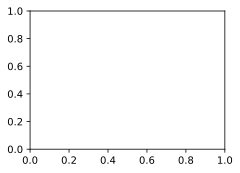

In [19]:
train(net, train_iter, vocab, lr, num_epochs, try_gpu())

In [ ]:
train(net, train_iter, vocab, lr, num_epochs, try_gpu(), use_random_iter=True)